# Robustness

Here we examine how robust the scoring is to the various choices we have made. Those choices include

- the measurement error ratios assumed on the data.
- the GP hyperparameter estimates
- the choice of GP covariance function.

We've already checked the robustness to the grid fineness resolution used.

Let's begin by loading the libraries we'll need.

In [1]:
import GPy
import sys
import os
sys.path.append(os.getenv("HOME") + "/Documents/Code/Emulation/GPyDifferentMetrics/")
from HaversineDist import Exponentialhaversine
import numpy as np
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import glob as glob
from cmocean import cm as cm
from Utilities import *


Now let's specify where the data and model runs are located, and load them.

In [2]:

GCM_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/'
gcm_SSTs = glob.glob(GCM_dir+'t*.txt')

gcm_mask = np.genfromtxt(GCM_dir+'mask.txt', dtype='int')

obs_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Observation_data/P3+_SST_anom/'
file = 'lambda_10.txt'
observations = np.genfromtxt(obs_dir+file, skip_header=1)
X_obs = observations[:,0:2]
y_obs = observations[:,2].reshape(-1,1)
var_ratios = observations[:,3][:,None]**2



## Robustness to the measurement error specification.

We'll start by 

In [3]:
np.unique(var_ratios)
#np.sqrt(var_ratios/var_ratios.min()*1.25)

array([ 0.015625,  0.0225  ,  0.027225,  0.030625,  0.034225,  0.04    ,
        0.046225,  0.0625  ,  0.070225,  0.075625,  0.09    ,  0.105625,
        0.112225,  0.1225  ,  0.16    ,  0.2025  ,  0.25    ,  0.3025  ,
        0.36    ])

### Robustness to choice of covariance function

In [5]:

from scaledheteroscedasticgaussian import ScaledHeteroscedasticGaussian
from gp_heteroscedastic_ratios import ScaledHeteroscedasticRegression

k3 = Exponentialhaversine(2, lengthscale=2000)
m3 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k3, noise_mult=1., 
                                     known_variances=var_ratios)
m3.optimize_restarts(10)



Warning - ARD must be False at the moment
Optimization restart 1/10, f = 202.7394228954263


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/10, f = 230.29148806886514
Optimization restart 3/10, f = 256.53567622663604
Optimization restart 4/10, f = 230.29148806674664
Optimization restart 5/10, f = 256.5357030669622
Optimization restart 6/10, f = 230.29148806788714


 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:198: RuntimeWarning:invalid value encountered in multiply
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


Optimization restart 7/10, f = 231.82055024028432
Optimization restart 8/10, f = 256.5356751695445
Optimization restart 9/10, f = 230.29148806663528
Optimization restart 10/10, f = 256.5356751098213


In [7]:
from HaversineDist import RBFhaversine
k2 = RBFhaversine(2, lengthscale=2000)

m2 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k2, noise_mult=1., 
                                     known_variances=var_ratios)
m2.optimize_restarts(10)




 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 210.39130977218076
Optimization restart 2/10, f = 256.5356827046478
Optimization restart 3/10, f = 256.5356752807978
Optimization restart 4/10, f = 256.5356752979961
Optimization restart 5/10, f = 256.53567528533733
Optimization restart 6/10, f = 256.53567531290304
Optimization restart 7/10, f = 256.535675109058
Optimization restart 8/10, f = 256.53567677338384
Optimization restart 9/10, f = 256.53567508321737
Optimization restart 10/10, f = 256.5356751842152



Name : gp
Objective : 210.39130977218076
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  rbf.variance                 |  8.85551166733  |      +ve      |        
  rbf.lengthscale              |  1725.16290875  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  16.0831967995  |      +ve      |        


 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:91: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


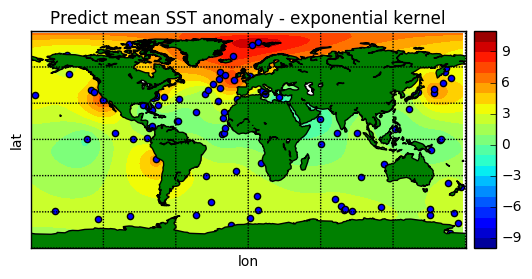

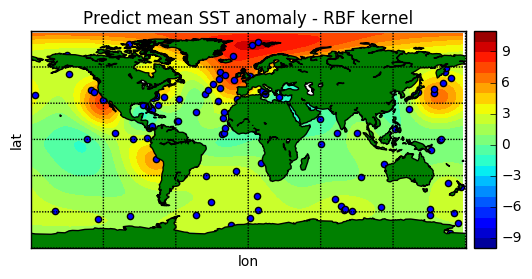

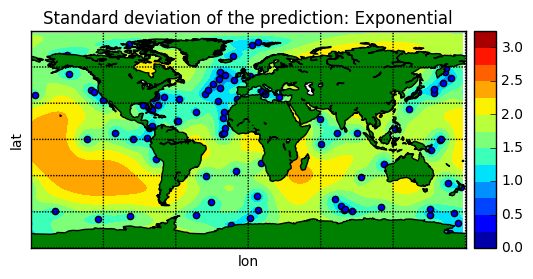

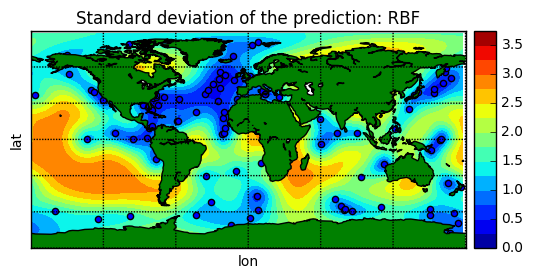

In [9]:
print(m2)
latsplot = np.arange(-90.0,90.0, 2.5)
longsplot = np.arange(-180.0,180.0, 2.5)
longgridplot, latgridplot = np.meshgrid(longsplot, latsplot)
X_plot=np.column_stack((longgridplot.flatten(), latgridplot.flatten())) # specifies the prediction locations

mu2,V2 = m2.predict_noiseless(X_plot)
mu3,V3 = m3.predict_noiseless(X_plot)


plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu3, X_obs)
plt.title('Predict mean SST anomaly - exponential kernel')
plt.figure(4)
map=plot_map(longgridplot, latgridplot, mu2, X_obs)
plt.title('Predict mean SST anomaly - RBF kernel')


plt.figure(5)
map=plot_map(longgridplot, latgridplot, np.sqrt(V3), X_obs, levels=np.arange(0,np.sqrt(V3).max()+1,0.25))
plt.title('Standard deviation of the prediction: Exponential')


plt.figure(6)
map=plot_map(longgridplot, latgridplot, np.sqrt(V2), X_obs, levels=np.arange(0,np.sqrt(V2).max()+1,0.25))
plt.title('Standard deviation of the prediction: RBF')

So we're getting pretty much the same mean trend, but much more certainty with the RBF kernel. Both of these things are to be expected.

In [27]:
count=0
gcm_runs = np.zeros((8,27186))
gcm_runs_label = gcm_SSTs.copy()

for file_name in gcm_SSTs:
    file_nm = file_name.split(GCM_dir)[-1]
    print(file_nm)
    # Read in GCM output.
    gcm_runs[count,:] = np.genfromtxt(file_name)
    gcm_runs_label[count] = file_nm.split(".txt")[0]
    count +=1

    
# Create the prediction grid - removing the land coordinates to save computation effort.
thinby=2
X_pred, out = ThinGrid(gcm_runs[0,:], gcm_mask, thinby=thinby)
gcm_thin = np.zeros((8, out.size))

for count in range(8):
    X_pred, out = ThinGrid(gcm_runs[count,:], gcm_mask, thinby=thinby)
    gcm_thin[count,:] = out.flatten()



tczyi.txt
tczyj.txt
tczyk.txt
tdgtg.txt
tdgth.txt
tdgti.txt
tdgtj.txt
tdgtk.txt


Let's predict on the grid, and compute the Cholesky decomposition of the covariance matrix.

In [33]:
mu, Cov = m2.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov+np.identity(mu.size)*0.01)

In [34]:
from Cholesky import *
loglikes = dlogmvnorm(gcm_thin.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)


In [35]:
print(loglikes)
print(orderings)
print(relative)

[-24482.43959426 -31898.63529036 -44637.57056546 -35423.08778596
 -20785.20547014 -88912.85389588 -31878.94933446 -50927.69077823]
[4 0 6 1 3 2 7 5]
[ -3697.2 -11113.4 -23852.4 -14637.9      0.  -68127.6 -11093.7 -30142.5]


In [36]:
dict = {'tdgth': '280 ppm',
        'tczyi': '315 ppm',
    'tdgtj': '350 ppm',
    'tczyj': '375 ppm',
    'tdgtg': '405 ppm',
    'tczyk': '475 ppm',
    'tdgtk': '560 ppm',
    'tdgti': '1000 ppm'}

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))

280 ppm:  relative loglike = 0.0
315 ppm:  relative loglike = -3697.2
350 ppm:  relative loglike = -11093.7
375 ppm:  relative loglike = -11113.4
405 ppm:  relative loglike = -14637.9
475 ppm:  relative loglike = -23852.4
560 ppm:  relative loglike = -30142.5
1000 ppm:  relative loglike = -68127.6


Hurray - we get the same results with the RBF kernel. Note I've had to add some noise to Cov in order to avoid numerical errors. This is usual with the RBF.

## Robustness to GP hyper-params.

In [44]:


k3 = Exponentialhaversine(2, lengthscale=2000)
m3 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k3, noise_mult=1., 
                                     known_variances=var_ratios)
m3.optimize_restarts(10)


print(m3)

Warning - ARD must be False at the moment
Optimization restart 1/10, f = 202.7394228954263
Optimization restart 2/10, f = 256.53567507862925


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/10, f = 230.29148806663545
Optimization restart 4/10, f = 256.53567407992784
Optimization restart 5/10, f = 230.2914880666579
Optimization restart 6/10, f = 230.29148806717902
Optimization restart 7/10, f = 230.29148806674556
Optimization restart 8/10, f = 256.5356777874232
Optimization restart 9/10, f = 230.29148806663449
Optimization restart 10/10, f = 256.5356762612704

Name : gp
Objective : 202.7394228954263
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99632407141  |      +ve      |        


In [48]:
m3.Exponential.lengthscale=2000
print(m3)
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov)
from Cholesky import *
loglikes = dlogmvnorm(gcm_thin.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))


Name : gp
Objective : 209.68996394720148
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |         2000.0  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99632407141  |      +ve      |        
280 ppm:  relative loglike = 0.0
315 ppm:  relative loglike = -24.2
350 ppm:  relative loglike = -24.9
375 ppm:  relative loglike = -28.8
405 ppm:  relative loglike = -35.1
475 ppm:  relative loglike = -80.8
560 ppm:  relative loglike = -127.5
1000 ppm:  relative loglike = -737.7


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1



Name : gp
Objective : 207.59223967166014
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  13.1116905673  |      +ve      |        
  Exponential.lengthscale      |  6999.98613355  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |            3.0  |      +ve      |        
280 ppm:  relative loglike = 0.0
350 ppm:  relative loglike = -58.2
315 ppm:  relative loglike = -60.5
375 ppm:  relative loglike = -67.1
405 ppm:  relative loglike = -79.4
475 ppm:  relative loglike = -189.8
560 ppm:  relative loglike = -301.6
1000 ppm:  relative loglike = -1828.3


In [ ]:
m3.Exponential.lengthscale=7000
print(m3)
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov)
from Cholesky import *
loglikes = dlogmvnorm(gcm_thin.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))

In [53]:
m3.optimize_restarts(10)
m3.Scaled_het_Gauss.noise_mult=3
print(m3)
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov)
from Cholesky import *
loglikes = dlogmvnorm(gcm_thin.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 203.05161596167824
Optimization restart 2/10, f = 256.5356809104111
Optimization restart 3/10, f = 256.535682998598
Optimization restart 4/10, f = 230.2914880782143
Optimization restart 5/10, f = 230.29148806677773
Optimization restart 6/10, f = 230.29148828776894
Optimization restart 7/10, f = 256.5356753572616
Optimization restart 8/10, f = 230.29148806674982
Optimization restart 9/10, f = 230.2914880672593
Optimization restart 10/10, f = 256.5356752443671

Name : gp
Objective : 206.5832004946184
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |            3.0  |      +ve      |        
280 ppm:  relative loglike = 0.0
350 ppm:  relative loglike = -51.8
315 ppm

In [55]:
m3.Scaled_het_Gauss.noise_mult=15
print(m3)
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov)
from Cholesky import *
loglikes = dlogmvnorm(gcm_thin.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))


Name : gp
Objective : 204.59303073786168
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |           15.0  |      +ve      |        
280 ppm:  relative loglike = 0.0
315 ppm:  relative loglike = -62.9
350 ppm:  relative loglike = -97.8
375 ppm:  relative loglike = -100.0
405 ppm:  relative loglike = -115.8
475 ppm:  relative loglike = -215.3
560 ppm:  relative loglike = -278.2
1000 ppm:  relative loglike = -1099.3


In [56]:
m3.optimize_restarts(10)
m3.Exponential.variance=3
print(m3)
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov)
from Cholesky import *
loglikes = dlogmvnorm(gcm_thin.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 202.7394228956218
Optimization restart 2/10, f = 230.29148806671657
Optimization restart 3/10, f = 256.53567831946054
Optimization restart 4/10, f = 256.5356776452395
Optimization restart 5/10, f = 230.2914880666532
Optimization restart 6/10, f = 256.53568378064347
Optimization restart 7/10, f = 230.29148806730774
Optimization restart 8/10, f = 256.5356752029918
Optimization restart 9/10, f = 233.24425467913989


 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:198: RuntimeWarning:invalid value encountered in multiply
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


Optimization restart 10/10, f = 256.5356751041129

Name : gp
Objective : 225.2681852956636
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |            3.0  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99632407141  |      +ve      |        
280 ppm:  relative loglike = 0.0
315 ppm:  relative loglike = -218.6
350 ppm:  relative loglike = -359.8
375 ppm:  relative loglike = -368.6
405 ppm:  relative loglike = -423.9
475 ppm:  relative loglike = -750.2
560 ppm:  relative loglike = -922.5
1000 ppm:  relative loglike = -3136.8


In [57]:
m3.optimize_restarts(10)
m3.Exponential.variance=20
print(m3)
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov)
from Cholesky import *
loglikes = dlogmvnorm(gcm_thin.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 202.7394228953523
Optimization restart 2/10, f = 256.5356772146916
Optimization restart 3/10, f = 230.29148806665816
Optimization restart 4/10, f = 230.2914880714296
Optimization restart 5/10, f = 230.29148810223515
Optimization restart 6/10, f = 256.53567511812827
Optimization restart 7/10, f = 256.5356758015679
Optimization restart 8/10, f = 230.29148806670247
Optimization restart 9/10, f = 256.5356750423897


 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:198: RuntimeWarning:invalid value encountered in multiply
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


Optimization restart 10/10, f = 230.29148806671782

Name : gp
Objective : 209.12115196701163
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |           20.0  |      +ve      |        
  Exponential.lengthscale      |  4778.82226708  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99636019992  |      +ve      |        
280 ppm:  relative loglike = 0.0
315 ppm:  relative loglike = -26.9
350 ppm:  relative loglike = -28.4
375 ppm:  relative loglike = -31.5
405 ppm:  relative loglike = -37.4
475 ppm:  relative loglike = -86.4
560 ppm:  relative loglike = -134.2
1000 ppm:  relative loglike = -781.6
